# Evaluate the models

In this notebook we run identical cells for each model we have tested. Models are shown below. Some of the hyper parameters are listed to give the reader a quick view of what was changing.

All models had training and validation data sampled randomly form the MS Coco train2017 file (which contain ~128k images). The test data was sampled from the MS Coco val2017 file. 

* Models named `random`, just sampled images and associated captions randomly from the data.
* Models named `sports` reduced the scope of data to only pictures including objects within the sports super-category in MS Coco. This reduced the size of the train2017 data from ~128k to ~23k images. Our hypothesis was that it would be easier to train a model with a more specific range of images vs a wide range of images.
* `everything` model was trained on the entire dataset. After splitting into train and val, this gave ~102k training and ~15k validation images.
* `sports_encoder` model used a different encoder. With one fully connected layer at the end rather than 2. This architecture is the more standard way of approaching and encoder/decoder model. We set hyper parameters equal to our best performing model: sports_v2. We are including results, but it is not posssible to recreate them using our code without manually changing some lines in the model.py file. `sports_encoder` was actually the best performing model.
* To see if a larger vocab helped the model to deal with unseen images better, the vocab for `sports_v5` was build from all the captions in the entire train2017 data set. 

The table includes some additional columns which should be explained:

* `captions_name`. This sets the name of the vocab and captions json files which are saved for each model. For example, `random_v1` has its captions files saved as `Datasets/coco/annotations/random_v1_train.json`, `Datasets/coco/annotations/random_v1_val.json`, and `Datasets/coco/annotations/random_v1_test.json`. The vocab file is saved as `vocabulary/random_v1word2idx.json`.
* `checkpoint folder`. These is the folder where model checkpoints and other meta data are saved. So `random_v1` model has checkpoints saved in `model/model_v1`. 
* Finally we show the notebook file name where the training was done to ease navigation through our folder.


| Model      | LSTM layers | embedding size | batch_size | freq_threshold | train_size.   |captions_name | checkpoint folder| training_notebook |
| -----------|:--------:   | :------------: | :--------: | :-----------:  | :------------:|------------- | ---------------- | ----------------- |
| random_v1  | 1           | 512            | 32         | 5              | 10k           | random_v1    | model_v1         | train_random_v1   |
| random_v2  | 3           | 1024           | 128        | 5              | 10k           | random_v1    | model_v1         | train_random_v2   |
| sports_v1  | 3           | 1024           | 128        | 5              | 10k           | sports_v1    | model_sports_v1  | train_sports      |
| sports_v2  | 3           | 512            | 128        | 4              | 15k           | sports_v2    | model_sports_v3  | train_sports2     |
| **Other Models** |       |                |            |                |               |              |                  |                   |
| sports_v4  | 3           | 512            | 64         | 5              | 15k           | sports_v4    | model_sports_v4  | train_sports2     |
| sports_v5  | 3           | 1024           | 64         | 5              | 20k           | sports_v5    | model_sports_v5  | train_sports      | 
| everything | 3           | 512            | 64         | 5              | 102k          | everything   | model_everything | train_sports2     |
| sports_encoder | 3       | 512            | 128        | 4              | 15k     | sports_encoder | model_sports_encoder | z_train_sports_enc|
| random_v3  | 3           | 1024           | 128        | 5              | 20k           | random_v3    | model_v3         | train_random_v3.  |




## Import libraries

In [17]:
%load_ext autoreload  # legacy from code dev, not strictly needed now
%autoreload 2

from get_loader import get_loader
from models import Encoder, Decoder
import torch
import torch.nn as nn
from utils import *
from PIL import Image
from nltk.translate import bleu_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
IMAGE_PATH = '../Datasets/coco/images/val2017' 
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'

FREQ_THRESHOLD = 5 # it actually doesn't matter what this number is as we use pre-defined vocabs for all evaluation
CAPS_PER_IMAGE = 1 # needs to be set to 1 due to the way we loop through the data loader
BATCH_SIZE = 1 
SHUFFLE = True
MODE = 'test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


## Model 1: random_v1




In [75]:
CAPTIONS_NAME = 'random_v1'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_v1'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)


MODEL_SUMMARY = 'data samlped from entire MS Coco train2017 / val2017\n' \
                'train/val/test size 10k/2k/2k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")



model summary information:
------
data samlped from entire MS Coco train2017 / val2017
train/val/test size 10k/2k/2k
frequency threshold: 5
vocab size: 3389
batch size: 32
embed size: 512
hidden size: 512
LSTM layers: 1

Length of testing dataloader: 2000.


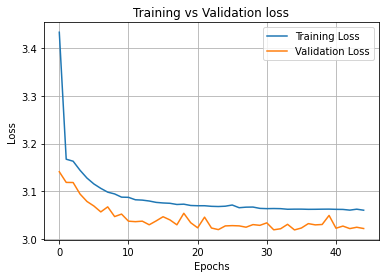

In [76]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

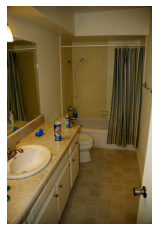

Predicted caption: a bathroom with a toilet and a toilet .
Original Captions:
0. A small and near bathroom that's inside someone's house.
1. Cleaning products are on the counter of the bathroom.
2. a bathroom with a long counter that has cleaning products on it 
3. A bathroom with a shower, toilet, and sink.
4. A full view of a bathroom with sink and toilet in the back. 


In [77]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [78]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 7min 4s, sys: 13.4 s, total: 7min 18s
Wall time: 1min 8s


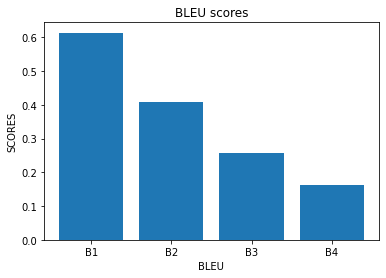

In [79]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [80]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 2: random_v2


In [69]:
CAPTIONS_NAME = 'random_v1'

captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_v1'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)


MODEL_SUMMARY = 'data samlped from entire MS Coco train2017 / val2017\n' \
                'train/val/test size 10k/2k/2k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")



model summary information:
------
data samlped from entire MS Coco train2017 / val2017
train/val/test size 10k/2k/2k
frequency threshold: 5
vocab size: 3389
batch size: 32
embed size: 512
hidden size: 512
LSTM layers: 1

Length of testing dataloader: 2000.


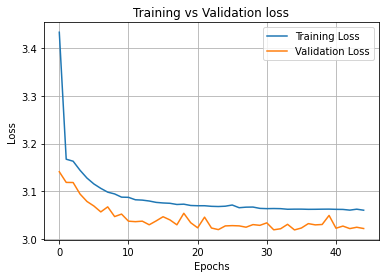

In [70]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

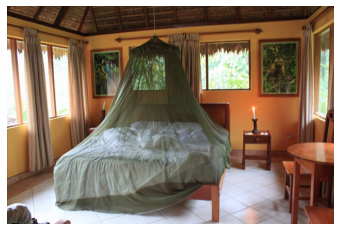

Predicted caption: a large bed with a bed and a bed .
Original Captions:
0. A green netted bed in a light filled bedroom.
1. Bed covered in mosquito netting in a bedroom with windows on three walls.
2. A bed in a hut covered in a bug net.
3. A bed with lots of pillows and blankets under a canopy.
4. Bed in room with candles covered by a mosquito net


In [71]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [72]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 6min 52s, sys: 13.9 s, total: 7min 6s
Wall time: 1min 9s


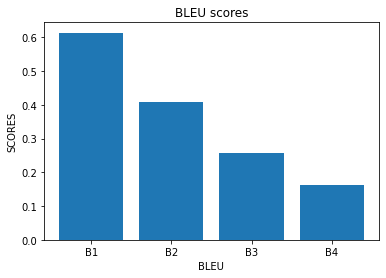

In [73]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [74]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 3 - sports "v1"


In [44]:
CAPTIONS_NAME = 'sports_v1'

captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v1'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 10k/2k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")


model summary information:
------
only images containing objects from sports super-category.
train/val/test size 10k/2k/1k
frequency threshold: 5
vocab size: 2110
batch size: 128
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


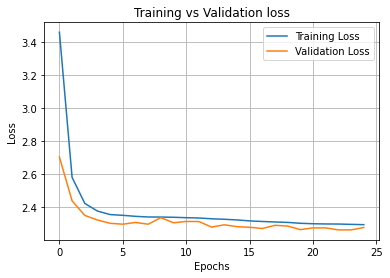

In [45]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

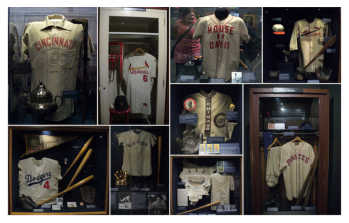

Predicted caption: a man is sitting on a skateboard in the water .
Original Captions:
0. Baseball memorabilia is displayed in glass stacked casings.
1. a glass enclosure with a variety of vintage baseball memorbilia
2. Photos of sports memorabilia including shirts, caps, and baseball bats.
3. Shots of many baseball uniforms on display as well as some baths.
4. Several museum displays of baseball uniforms and bats.


In [46]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [47]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 26s, sys: 6.59 s, total: 3min 33s
Wall time: 32.8 s


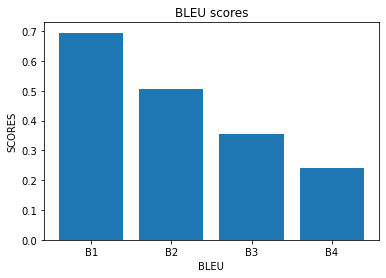

In [48]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [49]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 4 - sports_v2


In [51]:
CAPTIONS_NAME = 'sports_v2'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v3'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 4\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 4
vocab size: 2921
batch size: 128
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


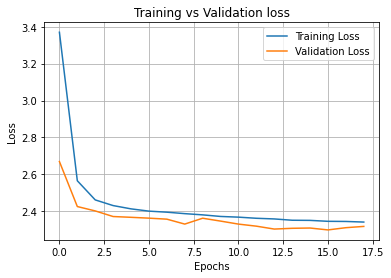

In [52]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

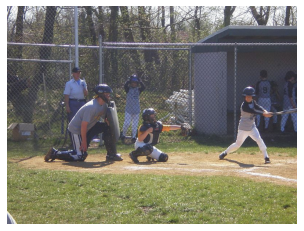

Predicted caption: a group of men standing on a field with a baseball bat .
Original Captions:
0. Little boys playing on a baseball field in baseball uniforms. 
1. An umpire officiates a game of little league baseball.
2. THERE IS A BOY PLAYING BASEBALL AT THE BASE BALL FIELD 
3. A baseball player holding a bat next to home plate.
4. A young boy swings a bat during a children's baseball game.


In [53]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [54]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 26s, sys: 6.61 s, total: 3min 33s
Wall time: 32.6 s


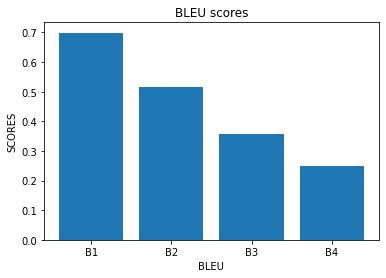

In [55]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [18]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 5 - sports_v4

The entire train2017 captoins data set was used to build the vocabulary

In [68]:
CAPTIONS_NAME = 'sports_v4'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/2k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512\n' \
                'vocab build using entire train2017 captions data'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v4'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 15k/2k/1k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


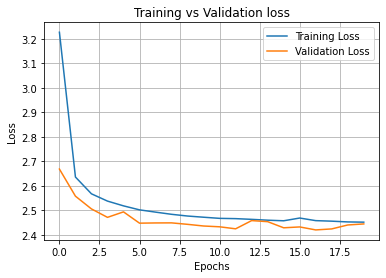

In [45]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

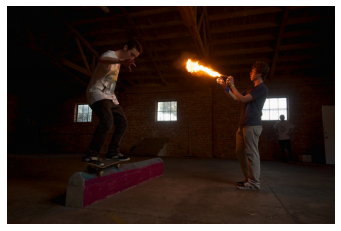

Predicted caption: a man riding a skateboard on a skateboard .
Original Captions:
0. A teenager shoots flames at a friend balancing on a skateboard.
1. a man rides his skateboard on a small ledge while another man lights the spray from a can on fire
2. A skateboarder on a rail in a  building with another man using a spray can as a blow torch.
3. A man ignites spray from a can next to his friend on a skateboard
4. The young man is practicing his tricks on his skateboard while the other is playing with fire.


In [46]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [22]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 51s, sys: 14.1 s, total: 4min 5s
Wall time: 1min 1s


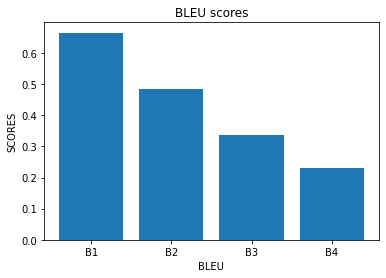

In [23]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [24]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 6 - sports_v5

All the sport data - 28k training size.

In [82]:
CAPTIONS_NAME = 'sports_v5'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v5'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 20k/3k/1k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 20k/3k/1k
frequency threshold: 5
vocab size: 2988
batch size: 64
embed size: 1024
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


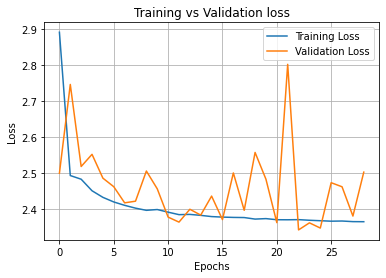

In [83]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

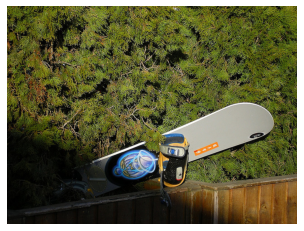

Predicted caption: a dog on a skateboard in a skate park .
Original Captions:
0. Snowboard stuck in a thick collection of trees. 
1. A snow board sticking out of the side of a tree.
2. SKATE BOARDER CRASHED INTO THE TREES JUMPING OVER A FENCE
3. a close up of a snow board in a bush
4. Snowboard atop of wooden structure next to evergreen plant.


In [84]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [85]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 31s, sys: 6.35 s, total: 3min 37s
Wall time: 32.1 s


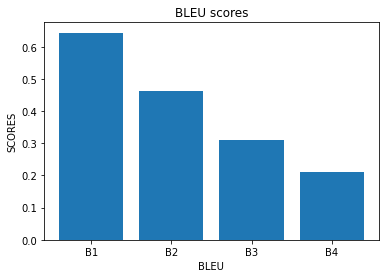

In [86]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [30]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 7 - everything

This has same parameters as model 2, but data set is restricted to images showing sports categories.

In [87]:
CAPTIONS_NAME = 'everything'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_everything'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'images sampled from entire train2017 data set\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
images sampled from entire train2017 data set
train/val/test size 102k/15k/5k
frequency threshold: 5
vocab size: 10192
batch size: 64
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 4952.


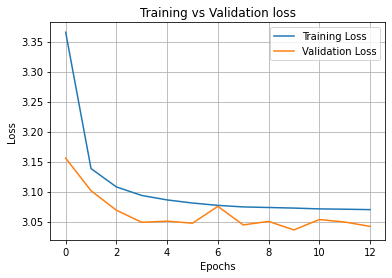

In [88]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

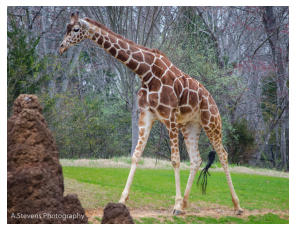

Predicted caption: a giraffe is standing in a field with a tree .
Original Captions:
0. The giraffe is walking toward a rock on a trail. 
1. The tall adult giraffe is standing next to a boulder.
2. there is a very tall giraffe that is in the wild
3. A giraffe in a field looking down at something.
4. A giraffe standing in the dirt near trees and rocks



In [89]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [90]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 18min 6s, sys: 34.8 s, total: 18min 41s
Wall time: 2min 54s


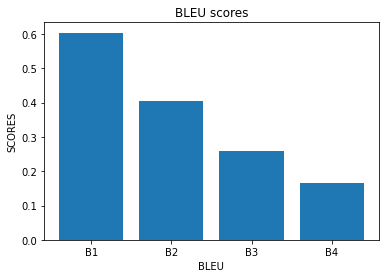

In [91]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [92]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 7 - sports "v2" but with modified encoder.

Our encoder has two fully connected layers at the end. We ran this model to compare with a more traditional architecture where you remove the last fc resnet layer and replace with just one layer. 

The training speed and final results are almost identical.

In [93]:
CAPTIONS_NAME = 'sports_encoder'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_encoder'
param = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                f'vocab size: {param["vocab_size"]}\n' \
                f'batch size: {param["batch_size"]}\n' \
                f'embed size: {param["embed_size"]}\n' \
                f'hidden size: {param["hidden_size"]}\n' \
                f'LSTM layers: {param["num_layers"]}\n'

print("model summary information:\n------\n{}".format(MODEL_SUMMARY))
print(f"Length of testing dataloader: {len(test_loader)}.")

model summary information:
------
only images containing objects from sports super-category.
train/val/test size 102k/15k/5k
frequency threshold: 5
vocab size: 2921
batch size: 128
embed size: 512
hidden size: 512
LSTM layers: 3

Length of testing dataloader: 938.


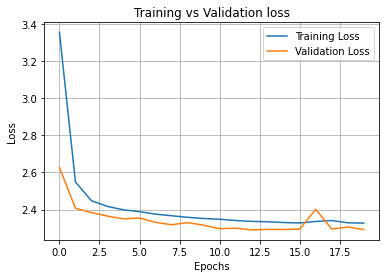

In [7]:
# for encoder and decoder
EMBED_SIZE = param['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param['hidden_size']
NUM_LAYERS = param['num_layers'] #hidden layers in LTSM
vocab_size = param['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

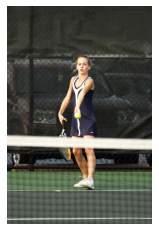

Predicted caption: a man holding a tennis racket on a tennis court .
Original Captions:
0. A tennis player getting ready to serve the ball 
1. A young woman on a tennis court preparing to serve the ball. 
2. A little girl on a tennis court that has a racquet.
3. A girl is playing tennis and is going to pitch the ball. 
4. woman in tennis garb preparing to serve tennis ball


In [8]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [9]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 8s, sys: 11.5 s, total: 3min 19s
Wall time: 50.4 s


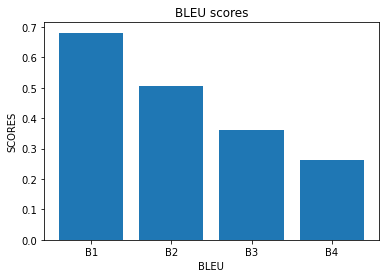

In [10]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [11]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Comparing the models

In [38]:
model_paths = ['../model/model_v1', '../model/model_v2']
compare_models_losses(model_paths)

AssertionError: Folder not found

In [ ]:
bleu_scores = [ [b1_0, b2_0, b3_0, b4_0], [b1, b2, b3, b4]]
comparing_bleu_scores(bleu_scores)

In [16]:
encoder.resnet.fc.in_features

2048